# Práctica  Escenarios de Estrés y Cambios de Régimen

## Objetivo (resumen)
Construir un motor interpretable de detección de regímenes (calma/crisis) y simulación multiactivo con cópulas,
capaz de generar escenarios de estrés y cuantificar pérdidas extremas (VaR 99% y ES/CVaR 99%).

## Datos

Se explora el movimiento diario, desde 2006-01-01 hasta hoy, de los siguientes activos:
- High Yield: HYG
- Bonos gobierno USA 10Y y 2Y (proxies líquidos): IEF (7–10Y Treasury) y SHY (1–3Y Treasury)
- Mercado (proxy para gráficos/regímenes): SPY (S&P 500)
- Yields DGS10 y DGS2 (FRED) como indicadores de tipos


Fuentes:
- Precios ajustados (acciones/ETFs): Yahoo Finance (via `yfinance`)
- Series macro/crediticias (yields y spread HY): FRED (via `pandas_datareader`)


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as st
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from datetime import datetime, timezone
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler

/Users/juanjo/Documents/MIAX/Tareas/Practica-Riesgos-MIAX/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Tickers a usar
tickers = [
    "GLD",
    "HYG",   # High Yield ETF (precio/retornos)
    "IEF",
    "SHY" # proxis líquidos para UST 10Y y 2Y (aprox.)
]

In [3]:
SEED = 42
np.random.seed(SEED)
FROM = "2006-01-01"
TO = datetime.now().date().isoformat()

# Anhadimos SPY
tickers.append("SPY") # mercado (S&P500)

# Series FRED (indicadores interpretables)
fred_series = {
    "DGS10": "UST_10Y_YIELD",          # 10Y yield
    "DGS2":  "UST_2Y_YIELD",           # 2Y yield
    "BAMLH0A0HYM2": "HY_OAS_SPREAD"    # spread HY
}

px = yf.download(
    tickers,
    start=FROM,
    end=TO,
    auto_adjust=True,
    progress=False)["Close"]

fred = pdr.DataReader(list(fred_series.keys()), "fred", FROM, TO)
fred = fred.rename(columns=fred_series)

# Eliminamos los dias que no haya precio (no bursatil)
px = px.dropna(axis=0, how="all")
fred = fred.dropna(axis=0, how="all")

# Eliminamos los tickers que no tengan precio
px = px.dropna(axis=1, how="all")
fred = fred.dropna(axis=1, how="all")

returns = np.log(px).diff().dropna()
closed_prices = pd.concat([px.add_prefix("PX_"), fred.add_prefix("FRED_")], axis=1)

print("Rango (Dias Bursatiles):", px.index.min().date(), "-", px.index.max().date())
print("Precios descargados:", px.shape[1], "activos |", list(px.columns))
print("FRED descargado:", fred.shape[1], "series |", list(fred.columns))
print("Retornos (log) shape:", returns.shape)
display(closed_prices)

Rango (Dias Bursatiles): 2006-01-03 - 2026-02-10
Precios descargados: 5 activos | ['GLD', 'HYG', 'IEF', 'SHY', 'SPY']
FRED descargado: 3 series | ['UST_10Y_YIELD', 'UST_2Y_YIELD', 'HY_OAS_SPREAD']
Retornos (log) shape: (4739, 5)


,PX_GLD,PX_HYG,PX_IEF,PX_SHY,PX_SPY,FRED_UST_10Y_YIELD,FRED_UST_2Y_YIELD,FRED_HY_OAS_SPREAD
2006-01-03,53.119999,NaN,49.726395,55.632435,87.463303,4.37,4.34,3.73
2006-01-04,53.299999,NaN,49.815300,55.687870,87.877434,4.36,4.31,3.69
2006-01-05,52.340000,NaN,49.827126,55.639324,87.932648,4.36,4.32,3.64
2006-01-06,53.720001,NaN,49.761936,55.653168,88.664406,4.38,4.36,3.56
2006-01-09,54.599998,NaN,49.785648,55.660107,88.892265,4.38,4.36,3.51
...,...,...,...,...,...,...,...,...
2026-02-04,453.970001,80.620003,95.510002,82.730003,686.190002,4.29,3.57,2.86
2026-02-05,441.880005,80.529999,96.070000,82.860001,677.619995,4.21,3.47,2.97
2026-02-06,455.459991,80.809998,96.070000,82.860001,690.619995,4.22,3.50,2.87
2026-02-09,467.029999,80.919998,96.089996,82.879997,693.950012,4.22,3.48,2.84


En esta práctica se utilizan ETFs líquidos (por ejemplo, SPY, IEF, SHY, GLD y HYG) como proxies de los activos financieros subyacentes
(renta variable, bonos gubernamentales, oro y crédito high yield).
La elección responde a criterios de **liquidez y coherencia económica**.

Los ETFs proporcionan **precios diarios ajustados**, negociados en mercado continuo, lo que permite construir retornos homogéneos
y comparables entre activos desde 2006 sin problemas de iliquidez o falta de observaciones.
Esto es especialmente relevante en el caso de la renta fija, donde los bonos individuales no cotizan diariamente y presentan
problemas de precios “stale”.

Además, los ETFs reflejan de forma agregada el comportamiento de su clase de activo
(p. ej. SPY para el mercado accionario estadounidense o IEF/SHY para la curva de tipos),
lo que los hace adecuados para el análisis de **regímenes de mercado y escenarios de estrés**.
De este modo, se prioriza la estabilidad estadística del dataset y la interpretabilidad económica de los resultados.


# Fase 1 — Detección de regímenes con Gaussian HMM (2 estados)

Modelizamos el “pulso” del mercado asumiendo que existen **dos regímenes latentes**: *calma* y *crisis*.
Para estimarlos, ajustamos un **Gaussian Hidden Markov Model (HMM)** con **2 estados** sobre una matriz de retornos diarios
(multiactivo), de forma que el modelo aprenda:

- La **distribución** de retornos típica en cada estado (media y covarianza).
- La **dinámica temporal** (probabilidad de permanecer en el estado o cambiar al otro).

Una vez entrenado, inferimos para cada día el estado más probable y lo **representamos sobre el S&P 500 (SPY)**,
coloreando el fondo: **Blanco = Calma**, **Azul = Crisis**.


In [4]:
############################# Configuracion para el modelo #############################

RV1 = 20          # RV corto (estrés agudo) -> cada 20 dias
D_MACRO = 20      # cambios "mensuales" para FRED (evita ruido semanal)
N_STATES = 2
N_ITER = 3000

SMOOTH = 40      # suavizado de prob. crisis
THR = 0.6       # umbral de crisis
MIN_LEN = 30     # duración mínima (en días) para aceptar un episodio
GAP_TOL = 15     # Si hay GAP_TOL dias entre crisis entendemos que es una falsa alarma y que seguimos en crisis

In [5]:

date_all_with_price = closed_prices.isna().any(axis=1)
start_date = date_all_with_price[date_all_with_price == False].index.min()

feat = pd.DataFrame(index=closed_prices.index)

# Mercado
feat["SPY_ret"] = returns["SPY"]
# Volatilidad movil anualizada
feat[f"SPY_RV{RV1}"] = returns["SPY"].rolling(RV1).std() * np.sqrt(252)

# Crédito (cambios, no niveles)
fred_hy = closed_prices["FRED_HY_OAS_SPREAD"].ffill()
feat[f"dHY_OAS_{D_MACRO}d"] = fred_hy.diff(D_MACRO)

# Tipos (cambios en pendiente, no nivel)
y10 = closed_prices["FRED_UST_10Y_YIELD"].ffill()
y2  = closed_prices["FRED_UST_2Y_YIELD"].ffill()

# Diferencia de rentabilidad entre los bonos de largo plazo y los de corto plazo
slope = (y10 - y2)
feat[f"dSLOPE_{D_MACRO}d"] = slope.diff(D_MACRO)

if "IEF" in returns.columns:
    feat["IEF_ret"] = returns["IEF"]
if "GLD" in returns.columns:
    feat["GLD_ret"] = returns["GLD"]

# Quitamos NaNs
feat = feat.loc[feat.index >= start_date].dropna()

In [6]:
# Winsorización, percentil 1 y 99
for c in feat.columns:
    lo, hi = feat[c].quantile([0.01, 0.99])
    feat[c] = feat[c].clip(lo, hi)

In [7]:
print("HMM: ", feat.index.min().date(), " - ", feat.index.max().date())
print("Features:", list(feat.columns))

# feat -> Camapana de Gauss
Z = StandardScaler().fit_transform(feat.values)

hmm = GaussianHMM(n_components=N_STATES, covariance_type="full", n_iter=N_ITER, random_state=SEED)
hmm.fit(Z)

crisis_prediction = pd.Series(hmm.predict(Z), index=feat.index, name="states")
crisis_probability = pd.DataFrame(hmm.predict_proba(Z), index=feat.index, columns=[0, 1])

# Etiquetar crisis con criterio económico (vol alta + spread widening + peor retorno)
results = pd.DataFrame({
    "SPY_ret_mean": feat["SPY_ret"].groupby(crisis_prediction).mean(),
    f"SPY_RV{RV1}_vol": feat[f"SPY_RV{RV1}"].groupby(crisis_prediction).mean(),
    "dHY_ret_mean": feat[f"dHY_OAS_{D_MACRO}d"].groupby(crisis_prediction).mean()
})

crisis_state = results[f"SPY_RV{RV1}_vol"].idxmax()

print("Transmat:", hmm.transmat_)
print("Crisis_state:", crisis_state)
print("Resumen por estado:")
results

HMM:  2007-05-09  -  2026-02-10
Features: ['SPY_ret', 'SPY_RV20', 'dHY_OAS_20d', 'dSLOPE_20d', 'IEF_ret', 'GLD_ret']
Transmat: [[0.98684711 0.01315289]
 [0.02082496 0.97917504]]
Crisis_state: 1
Resumen por estado:


,SPY_ret_mean,SPY_RV20_vol,dHY_ret_mean
states,,,
0,0.000673,0.106528,-0.106492
1,-0.000027,0.251493,0.160722


In [8]:
# Score: estrés = vol alta + subida de spread + retorno medio más bajo
scores = results[f"SPY_RV{RV1}_vol"] + results["dHY_ret_mean"].clip(lower=0) - results["SPY_ret_mean"]
print("Scores:\n", scores)

Scores:
 states
0    0.105855
1    0.412242
dtype: float64


In [9]:
def build_episodes(stress: pd.Series, min_len=15, gap_tol=5):
    dates = stress.index.to_numpy()
    stress_values = stress.astype(int).values

    # 0 + [episodios estres] + 0 -> Permite que veamos cambios por si empezamos o terminamos en crisis
    changes = np.diff(np.r_[0, stress_values, 0])
    starts = np.where(changes == 1)[0]
    ends   = np.where(changes == -1)[0]  # exclusivo

    episodes = []
    for a, b in zip(starts, ends):
        if (b - a) >= min_len:
            episodes.append([a, b])

    if not episodes:
        return []

    merged = [episodes[0]]
    for a, b in episodes[1:]:
        pa, pb = merged[-1]
        if (a - pb) <= gap_tol:
            merged[-1][1] = b
        else:
            merged.append([a, b])

    return [(dates[a], dates[b-1]) for a, b in merged]

In [10]:
p_crisis = crisis_probability[crisis_state]
p_crisis_smooth = p_crisis.rolling(SMOOTH).mean()

crisis = (p_crisis_smooth > THR).astype(int)
episodes = build_episodes(crisis, min_len=MIN_LEN, gap_tol=GAP_TOL)
print("N episodios:", len(episodes))
for episode in episodes:
    print(np.datetime_as_string(episode[0], unit='D'), " - ", np.datetime_as_string(episode[1], unit='D'))

N episodios: 11
2007-08-27  -  2007-10-12
2007-12-05  -  2010-01-15
2010-06-07  -  2010-10-15
2011-09-01  -  2012-02-02
2015-09-23  -  2015-11-05
2016-01-07  -  2016-04-18
2018-03-09  -  2018-05-03
2018-11-15  -  2019-02-25
2020-03-26  -  2020-12-23
2022-03-03  -  2023-03-01
2025-04-10  -  2025-06-20


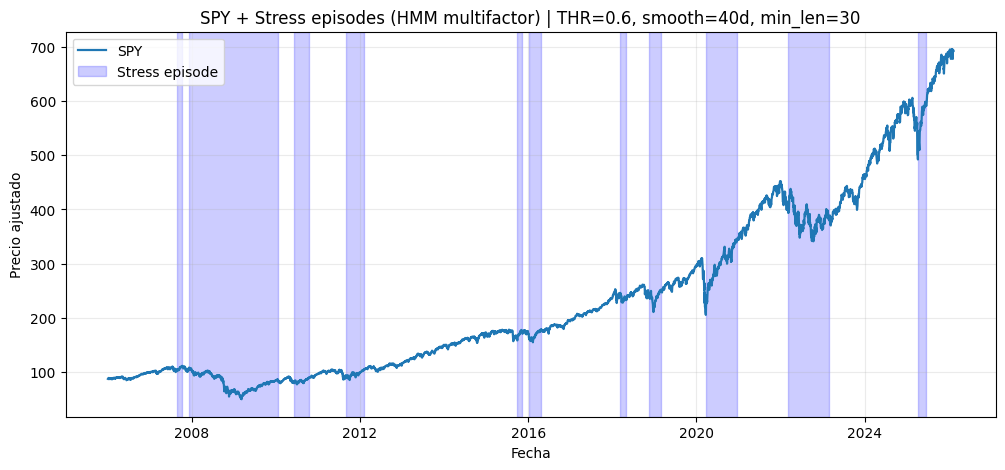

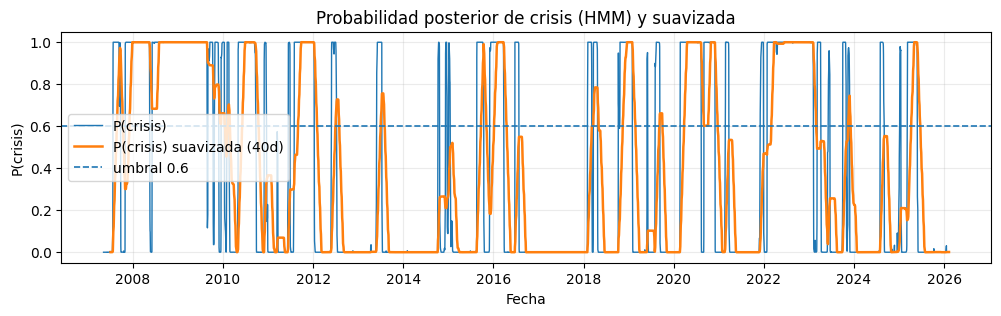

In [11]:
spy_plot = px["SPY"] #.reindex(feat_clip.index).ffill()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(spy_plot.index, spy_plot.values, linewidth=1.6, label="SPY")

for (a, b) in episodes:
    ax.axvspan(a, b, alpha=0.20, color="blue", label="Stress episode")

# leyenda sin duplicados
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), loc="upper left")

ax.set_title(f"SPY + Stress episodes (HMM multifactor) | THR={THR}, smooth={SMOOTH}d, min_len={MIN_LEN}")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio ajustado")
ax.grid(True, alpha=0.25)
plt.show()

# Plot de probabilidad (diagnóstico)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(p_crisis.index, p_crisis, linewidth=1.0, label="P(crisis)")
ax.plot(p_crisis_smooth.index, p_crisis_smooth, linewidth=1.8, label=f"P(crisis) suavizada ({SMOOTH}d)")
ax.axhline(THR, linestyle="--", linewidth=1.2, label=f"umbral {THR}")
ax.set_title("Probabilidad posterior de crisis (HMM) y suavizada")
ax.set_xlabel("Fecha")
ax.set_ylabel("P(crisis)")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

# Fase 2 — Anatomía del Riesgo 

En esta fase cuantificamos cómo cambian las distribuciones **individuales** de los retornos cuando el mercado pasa de *calma* a *crisis*.

Para cada activo calculamos, **condicional a cada estado** (Estado 0 = Calma, Estado 1 = Crisis):
- **Media** (retorno esperado diario)
- **Volatilidad** (desviación típica diaria)
- **Skewness** (asimetría)
- **Kurtosis (exceso)** (colas: >0 indica colas más pesadas que normal)

Además, respondemos:
1) ¿Cuánto aumenta la volatilidad de **HYG** al pasar de Estado 0 a Estado 1?  
2) ¿Sigue siendo **GLD** un activo refugio? (lo evaluamos por su media/vol en crisis y, como extra, su correlación con SPY en crisis).


In [12]:
# -----------------------------
# Checks
# -----------------------------
if "states" not in globals() or "crisis_state" not in globals():
    raise ValueError("No encuentro `states` y/o `crisis_state`. Ejecuta primero la Fase 1 (HMM).")

# -----------------------------
# 1) Estado 0/1: 0=Calma, 1=Crisis
# -----------------------------
wallet_crisis_prediction = (crisis_prediction == int(crisis_state)).astype(int)
wallet_crisis_prediction.name = "state01"

# -----------------------------
# 2) Retornos del universo (log) sin dropna global
# -----------------------------
universe = [
    "AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GLD","GME","GOOGL","JNJ",
    "JPM","MSFT","NVDA","PG","XOM",
    "IEF","SHY","HYG","SPY"
]
universe = [t for t in universe if t in px.columns]

R = np.log(px[universe]).diff()  # SIN dropna global
common_idx = R.index.intersection(wallet_crisis_prediction.index)
R = R.loc[common_idx]
wallet_crisis_prediction = wallet_crisis_prediction.loc[common_idx]

# -----------------------------
# 3) Momentos condicionales por estado
# -----------------------------
def moments(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({
        "N": df.count(),
        "mean_d": df.mean(),
        "vol_d": df.std(),
        "skew": df.skew(),
        "kurt_excess": df.kurt()   # exceso de kurtosis (Fisher)
    })
    out["mean_ann"] = out["mean_d"] * 252
    out["vol_ann"]  = out["vol_d"] * np.sqrt(252)
    return out

mom_calm   = moments(R[wallet_crisis_prediction == 0]).add_prefix("calm_")
mom_crisis = moments(R[wallet_crisis_prediction == 1]).add_prefix("crisis_")

tab = pd.concat([mom_calm, mom_crisis], axis=1)

tab["vol_ratio"] = tab["crisis_vol_ann"] / tab["calm_vol_ann"]
tab["vol_increase_%"] = (tab["vol_ratio"] - 1.0) * 100
tab["mean_diff_ann"] = tab["crisis_mean_ann"] - tab["calm_mean_ann"]
tab["kurt_diff"] = tab["crisis_kurt_excess"] - tab["calm_kurt_excess"]
tab["skew_diff"] = tab["crisis_skew"] - tab["calm_skew"]

# Si algún activo tiene pocos datos en un estado, mejor filtrarlo un poco
MIN_N = 400
mask = (tab["calm_N"] >= MIN_N) & (tab["crisis_N"] >= MIN_N)
tab_f = tab[mask].copy()

# -----------------------------
# 4) VISUALES
# -----------------------------
# (A) Top "amplificación" de volatilidad
topN = 12
rank = tab_f.sort_values("vol_increase_%", ascending=False).head(topN)

fig, ax = plt.subplots(figsize=(11, 5))
ax.barh(rank.index[::-1], rank["vol_increase_%"][::-1])
ax.set_title(f"Amplificación de volatilidad en crisis (top {topN})")
ax.set_xlabel("Aumento % de vol anualizada (Crisis vs Calma)")
ax.grid(True, alpha=0.25)
plt.show()

# (B) Scatter: vol crisis vs vol calma (línea 45º)
fig, ax = plt.subplots(figsize=(7, 6))
x = tab_f["calm_vol_ann"].values
y = tab_f["crisis_vol_ann"].values
ax.scatter(x, y)

mx = np.nanmax([x.max(), y.max()])
ax.plot([0, mx], [0, mx], linestyle="--", linewidth=1.2)  # línea 45º

# Etiquetar solo algunos (los más relevantes) para no saturar
labels = tab_f.index.tolist()
for t in labels:
    ax.annotate(t, (tab_f.loc[t, "calm_vol_ann"], tab_f.loc[t, "crisis_vol_ann"]), fontsize=9)

ax.set_title("Vol anualizada: Crisis vs Calma (línea 45º)")
ax.set_xlabel("Vol anualizada (Calma)")
ax.set_ylabel("Vol anualizada (Crisis)")
ax.grid(True, alpha=0.25)
plt.show()

# (C) Mean anualizada: comparación Calma vs Crisis (top 10 por peor media en crisis)
topM = 10
rank_mean = tab_f.sort_values("crisis_mean_ann").head(topM)  # <- aquí definimos rank_mean

fig, ax = plt.subplots(figsize=(11, 5))
idx = np.arange(len(rank_mean))
ax.bar(idx - 0.2, rank_mean["calm_mean_ann"].values, width=0.4, label="Calma")
ax.bar(idx + 0.2, rank_mean["crisis_mean_ann"].values, width=0.4, label="Crisis")
ax.set_xticks(idx)
ax.set_xticklabels(rank_mean.index, rotation=0)
ax.set_title(f"Media anualizada por estado (top {topM} por peor media en crisis)")
ax.set_ylabel("Mean anualizada")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()


# (D) Distribuciones (hist) para HYG y GLD por estado
def plot_hist_asset(ticker, bins=70):
    if ticker not in R.columns:
        print(f"[WARN] {ticker} no está en retornos.")
        return
    r0 = R.loc[wallet_crisis_prediction == 0, ticker].dropna()
    r1 = R.loc[wallet_crisis_prediction == 1, ticker].dropna()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(r0.values, bins=bins, density=True, alpha=0.55, label="Calma")
    ax.hist(r1.values, bins=bins, density=True, alpha=0.55, label="Crisis")
    ax.set_title(f"Distribución de retornos diarios (log) — {ticker}")
    ax.set_xlabel("Retorno diario")
    ax.set_ylabel("Densidad")
    ax.grid(True, alpha=0.25)
    ax.legend()
    plt.show()

plot_hist_asset("HYG")
plot_hist_asset("GLD")

# (E) “Mapa rápido” de colas/asimetría (top por kurtosis diff)
topK = min(15, len(tab_f))
rank_k = tab_f.sort_values("kurt_diff", ascending=False).head(topK)
vals = np.vstack([rank_k["calm_kurt_excess"].values, rank_k["crisis_kurt_excess"].values])

fig, ax = plt.subplots(figsize=(12, 2.6))
im = ax.imshow(vals, aspect="auto")
ax.set_yticks([0,1])
ax.set_yticklabels(["Calma (kurt excess)", "Crisis (kurt excess)"])
ax.set_xticks(np.arange(topK))
ax.set_xticklabels(rank_k.index, rotation=45, ha="right")
ax.set_title(f"Kurtosis (exceso) — top {topK} por aumento en crisis")
plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
plt.show()

# -----------------------------
# 5) Respuestas directas a las preguntas (HYG y GLD)
# -----------------------------
print("================= RESPUESTAS FASE 2 =================")

if "HYG" in tab.index:
    hyg = tab.loc["HYG"]
    print(f"(HYG) Vol anualizada Calma:  {hyg['calm_vol_ann']:.4f}")
    print(f"(HYG) Vol anualizada Crisis: {hyg['crisis_vol_ann']:.4f}")
    print(f"(HYG) Aumento (%):           {hyg['vol_increase_%']:.2f}%  | Ratio: {hyg['vol_ratio']:.3f}")
else:
    print("(HYG) No disponible en el dataset.")

if "GLD" in tab.index:
    gld = tab.loc["GLD"]
    print(f"(GLD) Mean anualizada Calma:  {gld['calm_mean_ann']:.4f}")
    print(f"(GLD) Mean anualizada Crisis: {gld['crisis_mean_ann']:.4f}  | Δ: {gld['mean_diff_ann']:.4f}")
    print(f"(GLD) Vol anualizada Calma:   {gld['calm_vol_ann']:.4f}")
    print(f"(GLD) Vol anualizada Crisis:  {gld['crisis_vol_ann']:.4f}  | Ratio: {gld['vol_ratio']:.3f}")

    # Extra: correlación GLD vs SPY condicional
    if "SPY" in R.columns:
        corr_calm = R.loc[wallet_crisis_prediction == 0, "GLD"].corr(R.loc[wallet_crisis_prediction == 0, "SPY"])
        corr_cris = R.loc[wallet_crisis_prediction == 1, "GLD"].corr(R.loc[wallet_crisis_prediction == 1, "SPY"])
        print(f"(GLD vs SPY) Corr Calma: {corr_calm:.3f} | Corr Crisis: {corr_cris:.3f}")
else:
    print("(GLD) No disponible en el dataset.")


ValueError: No encuentro `states` y/o `crisis_state`. Ejecuta primero la Fase 1 (HMM).

## Fase 3 — Cuando la diversificación falla (cópulas)

### 1) Correlación Pearson por régimen
- Se calcula la matriz de correlación de retornos diarios **condicional a cada estado** (HMM).
- Evidencia típica: en *Crisis* aumenta la **correlación media off-diagonal** y la distribución de correlaciones se desplaza hacia valores altos.
- En el subuniverso de **risk assets** (equity + HY) el efecto suele ser más marcado que cuando mezclamos defensivos (bonos/oro).

### 2) t-cópula multivariante (dependencia en colas)
- Se ajusta una **t-cópula** en cada régimen usando pseudo-observaciones (ranks → U(0,1)).
- La t-cópula introduce dependencia en colas mediante los **grados de libertad**:
  - **Alto** ⇒ comportamiento cercano a Gaussiana (colas “finas”) → típico de *Calma*.
  - **Bajo** ⇒ colas gruesas y más probabilidad de extremos conjuntos → típico de *Crisis*.

### 3) Extra: Clayton (bivariada) para cola izquierda
- Se usa **Clayton** como contraste específico de *riesgo*, ya que modela **dependencia de cola inferior**.
- A partir de Kendall  se obtiene theta y la métrica lambda (probabilidad de caídas conjuntas).
- En crisis se observan **pares con lambda significativamente mayor**, apoyando que la diversificación falla precisamente en la cola.

In [13]:
# Subconjuntos para interpretacion
equities = ["AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GME","GOOGL","JNJ","JPM","MSFT","NVDA","PG","XOM"]
def_assets  = ["IEF","SHY","GLD"]
risk_assets = ["HYG"] + equities

wallet = risk_assets + def_assets

print("Activos totales:", len(wallet), "| Risk assets:", len(risk_assets), "| Defensivos:", len(def_assets))

Activos totales: 18 | Risk assets: 15 | Defensivos: 3


In [14]:
#Descarga de todos los tickers
wallet_px = yf.download(
    wallet,
    start=FROM,
    end=TO,
    auto_adjust=True,
    progress=False)["Close"]

In [15]:
# Retornos log (sin dropna global)
wallet_returns = np.log(wallet_px).diff()

print("Dias con datos en HMM:", len(crisis_prediction))
print("Dias con datos en la cartera:", len(wallet_returns))

# Cogemos los dias comunes entre HMM y los precios de la cartera
common_idx = wallet_returns.index.intersection(crisis_prediction.index)
wallet_crisis_prediction = crisis_prediction.loc[common_idx]
wallet_returns = wallet_returns.loc[common_idx]

print("Dias en comun:", len(wallet_returns), "| Dias de crisis:", 100 * wallet_crisis_prediction.mean(), "%")

Dias con datos en HMM: 4720
Dias con datos en la cartera: 5058
Dias en comun: 4720 | Dias de crisis: 38.516949152542374 %


In [16]:
def vec_offdiag(df: pd.DataFrame):
    values = df.values
    mask = ~np.eye(values.shape[0], dtype=bool)
    return values[mask]

def offdiag_mean(df: pd.DataFrame) -> float:
    return np.nanmean(vec_offdiag(df))

In [17]:
# -----------------------------
# 1) Correlación Pearson por régimen
# -----------------------------

# Minimo numero de dias que tenemos que tener un ticker en la cartera para considerarlo
TICKER_MIN_SAMPLES = 400

calm_state = 0 if crisis_state else 1

wallet_calm_returns = wallet_returns.loc[wallet_crisis_prediction == calm_state]
wallet_crisis_returns = wallet_returns.loc[wallet_crisis_prediction == crisis_state]

# Nos quedamos los tickers que tengan suficientes datos en ambos regimenes
tickers_to_keep = []
for c in wallet_returns.columns:
    n0 = wallet_calm_returns[c].count()
    n1 = wallet_crisis_returns[c].count()
    if (n0 >= TICKER_MIN_SAMPLES) and (n1 >= TICKER_MIN_SAMPLES):
        tickers_to_keep.append(c)


wallet_calm_returns = wallet_calm_returns[tickers_to_keep]
wallet_crisis_returns = wallet_crisis_returns[tickers_to_keep]

wallet_calm_correlation = wallet_calm_returns.corr(method="pearson")
wallet_crisis_correlation = wallet_crisis_returns.corr(method="pearson")

print(f"Activos con N >= {TICKER_MIN_SAMPLES} en ambos regimenes: {len(tickers_to_keep)}")
print("Corr media off-diag (Calma):  ", offdiag_mean(wallet_calm_correlation))
print("Corr media off-diag (Crisis): ", offdiag_mean(wallet_crisis_correlation))


Activos con N >= 400 en ambos regimenes: 18
Corr media off-diag (Calma):   0.13954734960016854
Corr media off-diag (Crisis):  0.28530944694124183


In [18]:
risk_tickers = [t for t in risk_assets if t in tickers_to_keep]
risk_tickers_calm_returns = wallet_calm_returns[risk_tickers].corr()
risk_tickers_crisis_returns = wallet_calm_returns[risk_tickers].corr()
print(f"Risk Assets con N >= {TICKER_MIN_SAMPLES} en ambos regimenes: {len(risk_tickers)}")
print("Corr media off-diag (Calma):  ", offdiag_mean(risk_tickers_calm_returns))
print("Corr media off-diag (Crisis): ", offdiag_mean(risk_tickers_crisis_returns))

Risk Assets con N >= 400 en ambos regimenes: 15
Corr media off-diag (Calma):   0.20996900417855507
Corr media off-diag (Crisis):  0.20996900417855507


In [19]:
def plot_heatmap_corr(C: pd.DataFrame, title: str, vmin=-1, vmax=1):
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(C.values, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_xticks(range(C.shape[1]))
    ax.set_yticks(range(C.shape[0]))
    ax.set_xticklabels(C.columns, rotation=90)
    ax.set_yticklabels(C.index)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
    ax.grid(False)
    plt.show()

### Gráficos

In [20]:
V_MIN = -1
V_MAX = 1
GROUP_RANGE = 0.03

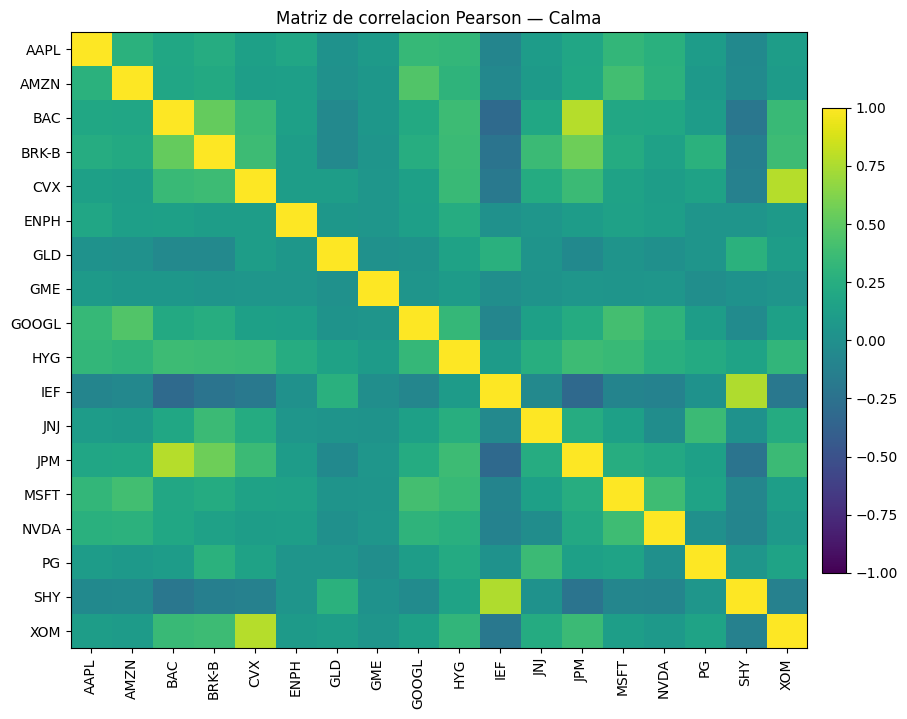

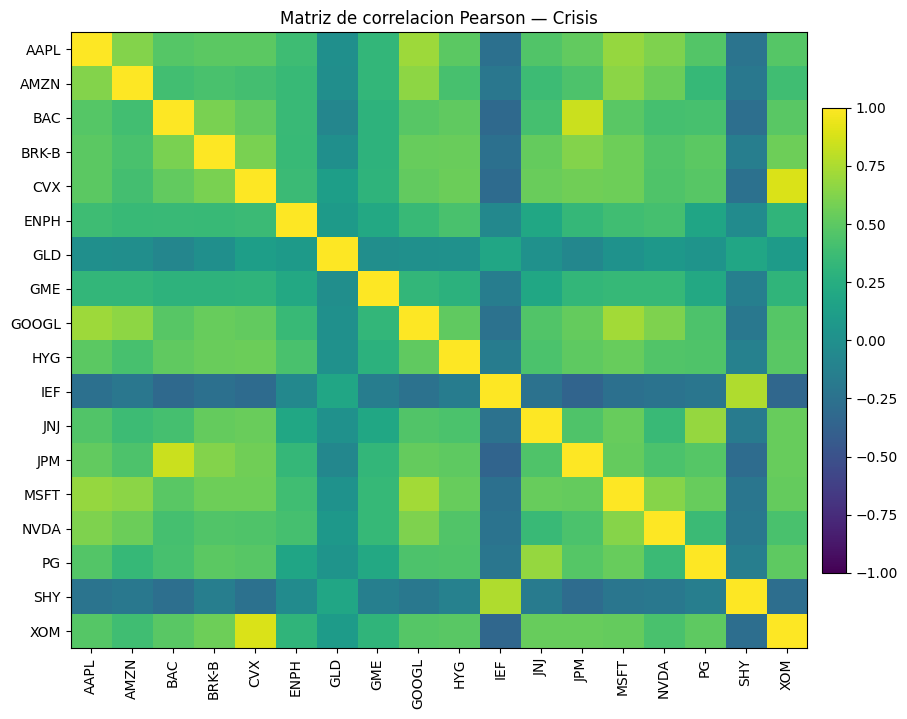

In [21]:
plot_heatmap_corr(wallet_calm_correlation, "Matriz de correlacion Pearson — Calma", vmin=V_MIN, vmax=V_MAX)
plot_heatmap_corr(wallet_crisis_correlation, "Matriz de correlacion Pearson — Crisis", vmin=V_MIN, vmax=V_MAX)

#### Visualización de las correlaciones en grupos de bins

Visualizamos los grupos de las correlaciones de ambas carteras, agrupados por bins

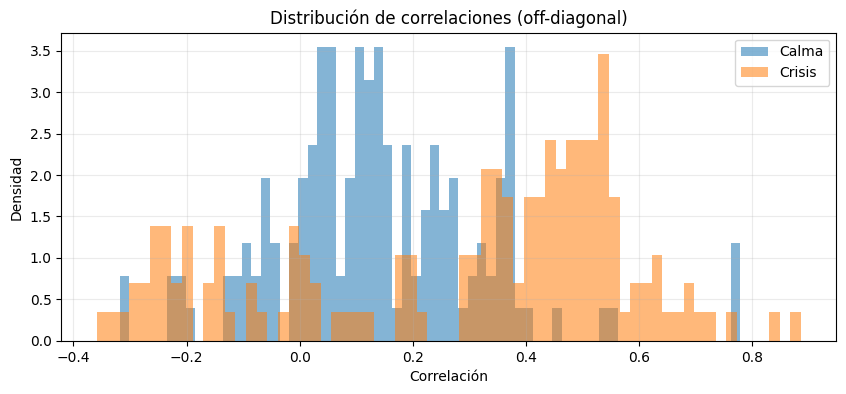

In [22]:
wallet_calm_correlation_values = vec_offdiag(wallet_calm_correlation)
wallet_crisis_correlation_values = vec_offdiag(wallet_crisis_correlation)

bins = int((V_MAX - V_MIN) / GROUP_RANGE)
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(wallet_calm_correlation_values, bins=bins, density=True, alpha=0.55, label="Calma")
ax.hist(wallet_crisis_correlation_values, bins=bins, density=True, alpha=0.55, label="Crisis")
ax.set_title("Distribución de correlaciones (off-diagonal)")
ax.set_xlabel("Correlación")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

### Cópulas

In [23]:
def pseudo_obs(df: pd.DataFrame) -> np.ndarray:
    """Pseudo-observaciones U(0,1) via ranks: u = rank/(n+1)."""
    X = df.values
    n, k = X.shape
    U = np.empty_like(X, dtype=float)
    for j in range(k):
        col = X[:, j]
        # rankdata maneja empates
        r = st.rankdata(col, method="average")
        U[:, j] = r / (n + 1.0)
    return U

def nearest_psd(A: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """Proyecta a PSD por clipping de eigenvalores."""
    A = 0.5 * (A + A.T)
    w, V = np.linalg.eigh(A)
    w = np.maximum(w, eps)
    B = (V * w) @ V.T
    # normalizar a correlación (diag = 1)
    d = np.sqrt(np.diag(B))
    B = B / np.outer(d, d)
    return 0.5 * (B + B.T)

def t_tail_dependence(rho: float, nu: float) -> float:
    """
    Coeficiente de dependencia en cola (simétrica) para t-copula:
    λ = 2 * t_{nu+1}(-sqrt((nu+1)*(1-rho)/(1+rho)))
    """
    if rho >= 0.999999:
        return 1.0
    if rho <= -0.999999:
        return 0.0
    a = -np.sqrt((nu + 1.0) * (1.0 - rho) / (1.0 + rho))
    return 2.0 * st.t.cdf(a, df=nu + 1.0)


def fit_t_copula_ifm(df: pd.DataFrame, nu_grid, shrink=0.02):

    X = df.dropna(axis=0, how="any")

    U = pseudo_obs(X)
    k = U.shape[1]
    ll_list = []

    for nu in nu_grid:
        # Transformación t
        Z = st.t.ppf(U, df=nu)
        # Correlación en el espacio latente
        Rho = np.corrcoef(Z, rowvar=False)
        # Shrinkage leve para estabilidad
        Rho = (1 - shrink) * Rho + shrink * np.eye(k)
        Rho = nearest_psd(Rho)

        # log c(u) = log f_tk(Z;nu,Rho) - sum log f_t1(Z_i;nu)
        mvt = st.multivariate_t(loc=np.zeros(k), shape=Rho, df=nu)
        ll_m = mvt.logpdf(Z).sum()
        ll_u = st.t.logpdf(Z, df=nu).sum()
        ll = ll_m - ll_u
        ll_list.append((nu, ll, len(X), k))

    ll_df = pd.DataFrame(ll_list, columns=["nu", "loglik", "N", "K"]).sort_values("loglik", ascending=False)
    nu_hat = int(ll_df.iloc[0]["nu"])

    # Re-estimar Rho con nu_hat
    Z = st.t.ppf(U, df=nu_hat)
    Rho = np.corrcoef(Z, rowvar=False)
    Rho = (1 - shrink) * Rho + shrink * np.eye(k)
    Rho = nearest_psd(Rho)

    return nu_hat, Rho, ll_df, X.columns

In [24]:
print("--- Ajuste t-copula (multivariante) ---")
print("Activos usados para copula:", tickers_to_keep)

wallet_calm_returns = wallet_calm_returns.dropna(how="any")
wallet_crisis_returns = wallet_crisis_returns.dropna(how="any")

nu_grid = [1,2,3,4,5,6,7,8,9,10,12,15,20,30,50,80, 100]
calm_nu, nu_calm_corr, calm_ll, calm_columns = fit_t_copula_ifm(wallet_calm_returns, nu_grid=nu_grid, shrink=0.02)
crisis_nu, nu_crisis_corr, crisis_ll, crisis_columns = fit_t_copula_ifm(wallet_crisis_returns, nu_grid=nu_grid, shrink=0.02)

# Un valor alto indica colas mas grandes (mas separados). Un valor pequenho indica que los activos estan mas correlacionados
print(f"t-copula Calma:  nu_hat = {calm_nu}")
print(f"t-copula Crisis: nu_hat = {crisis_nu}")

--- Ajuste t-copula (multivariante) ---
Activos usados para copula: ['AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GLD', 'GME', 'GOOGL', 'HYG', 'IEF', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'SHY', 'XOM']
t-copula Calma:  nu_hat = 15
t-copula Crisis: nu_hat = 10


In [25]:
# Plot ll vs nu
def plot_ll(ll_df, title):
    tmp = ll_df.sort_values("nu")
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(tmp["nu"], tmp["loglik"], marker="o")
    ax.set_title(title)
    ax.set_xlabel("nu (df)")
    ax.set_ylabel("log-likelihood (copula)")
    ax.grid(True, alpha=0.25)
    plt.show()

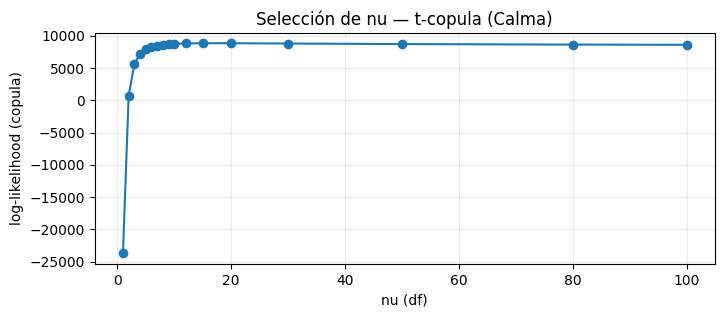

t-copula — Calma (mejores nu por log-likelihood)


,nu,loglik,N,K
11,15,8829.183544,2477,18
12,20,8829.101260,2477,18
10,12,8795.879798,2477,18
13,30,8783.495393,2477,18
9,10,8735.224920,2477,18
14,50,8696.852515,2477,18
8,9,8681.231256,2477,18
15,80,8616.972936,2477,18
7,8,8599.478002,2477,18
16,100,8583.183935,2477,18


In [26]:
plot_ll(calm_ll, "Selección de nu — t-copula (Calma)")
print("t-copula — Calma (mejores nu por log-likelihood)")
calm_ll.head(10)

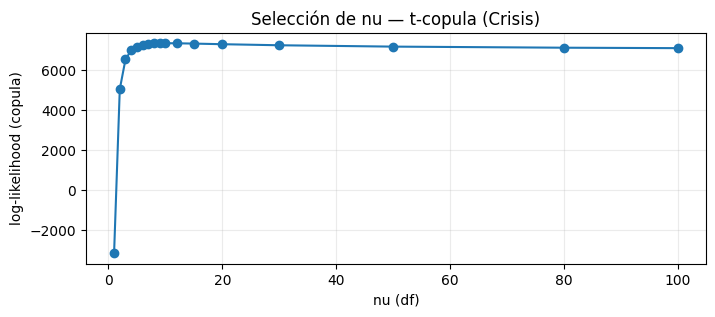

t-copula — Crisis (mejores nu por log-likelihood)


,nu,loglik,N,K
9,10,7354.005248,1008,18
10,12,7350.829874,1008,18
8,9,7350.410592,1008,18
7,8,7340.141129,1008,18
11,15,7335.596264,1008,18
6,7,7318.201263,1008,18
12,20,7304.874290,1008,18
5,6,7274.630524,1008,18
13,30,7252.008788,1008,18
4,5,7187.453847,1008,18


In [27]:
plot_ll(crisis_ll, "Selección de nu — t-copula (Crisis)")
print("t-copula — Crisis (mejores nu por log-likelihood)")
crisis_ll.head(10)

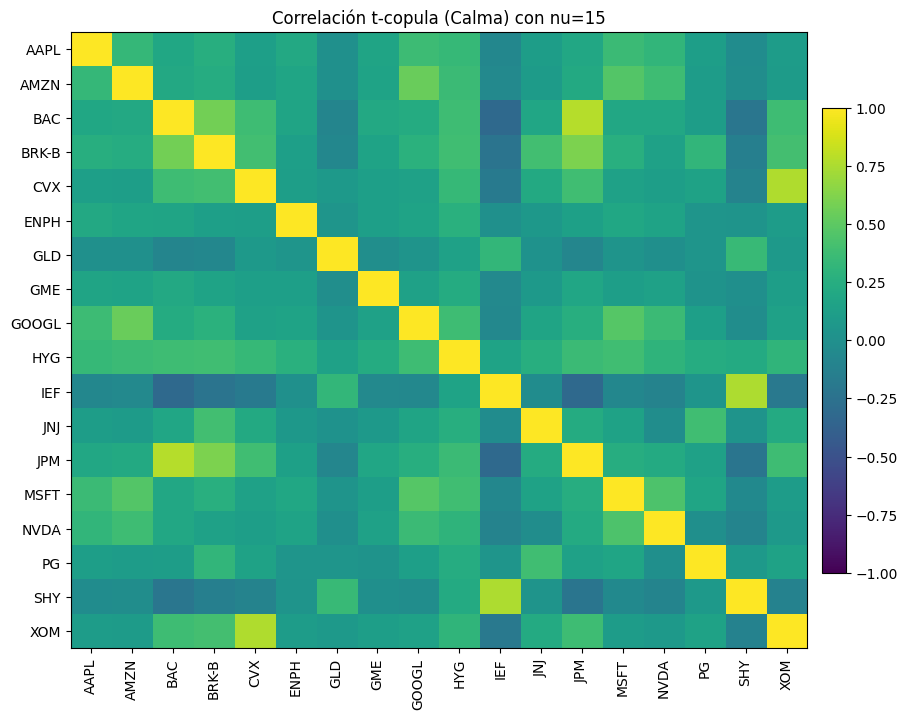

In [28]:
nu_calm_corr_df = pd.DataFrame(nu_calm_corr, index=calm_columns, columns=calm_columns)
plot_heatmap_corr(nu_calm_corr_df, f"Correlación t-copula (Calma) con nu={calm_nu}", vmin=-1, vmax=1)

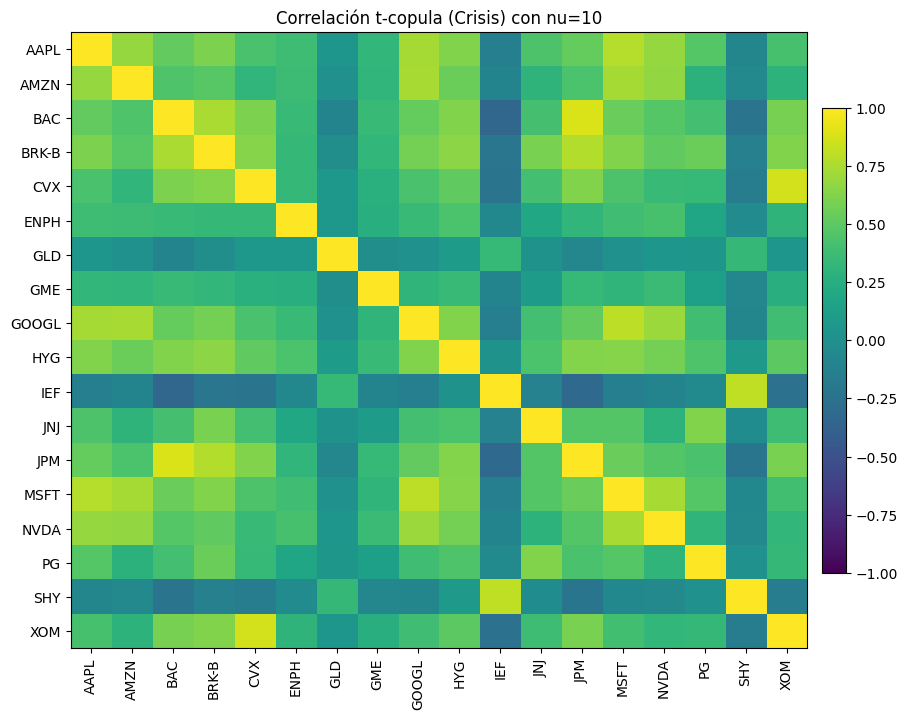

In [29]:
nu_crisis_corr_df = pd.DataFrame(nu_crisis_corr, index=crisis_columns, columns=crisis_columns)
plot_heatmap_corr(nu_crisis_corr_df, f"Correlación t-copula (Crisis) con nu={crisis_nu}", vmin=-1, vmax=1)

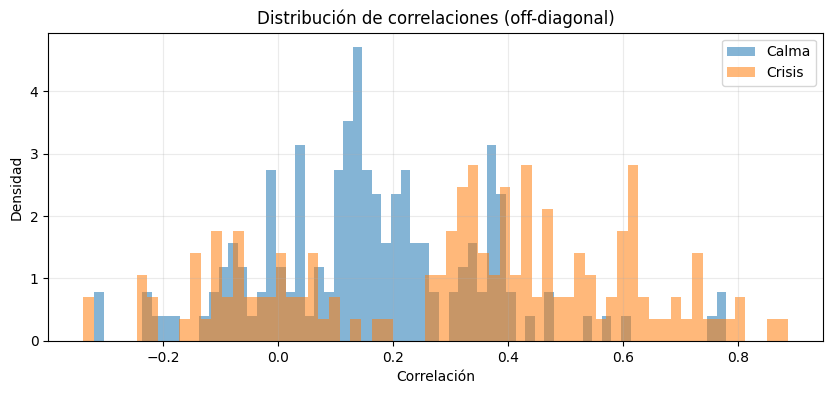

In [31]:
copula_calm_correlation_values = vec_offdiag(nu_calm_corr_df)
copula_crisis_correlation_values = vec_offdiag(nu_crisis_corr_df)

bins = int((V_MAX - V_MIN) / GROUP_RANGE)
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(copula_calm_correlation_values, bins=bins, density=True, alpha=0.55, label="Calma")
ax.hist(copula_crisis_correlation_values, bins=bins, density=True, alpha=0.55, label="Crisis")
ax.set_title("Distribución de correlaciones (off-diagonal)")
ax.set_xlabel("Correlación")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

In [32]:
def pair_table_taildep(Rho, cols, nu, top=12):
    cols = list(cols)
    out = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            rho = float(Rho[i, j])
            lam = t_tail_dependence(rho, nu)
            out.append((cols[i], cols[j], rho, lam))
    df = pd.DataFrame(out, columns=["asset_i","asset_j","rho_latent","lambda_tail"])
    df = df.sort_values("lambda_tail", ascending=False)
    return df.head(top), df


top1, all1 = pair_table_taildep(nu_crisis_corr, crisis_columns, crisis_nu, top=12)

In [33]:
top0, all0 = pair_table_taildep(nu_calm_corr, calm_columns, calm_nu, top=12)
print("t-copula — Top tail dependence (Calma)")
top0.head(12)

t-copula — Top tail dependence (Calma)


,asset_i,asset_j,rho_latent,lambda_tail
42,BAC,JPM,0.780101,0.178881
74,CVX,XOM,0.765248,0.164003
130,IEF,SHY,0.756226,0.155604
56,BRK-B,JPM,0.609247,0.066268
33,BAC,BRK-B,0.573748,0.053782
23,AMZN,GOOGL,0.539889,0.043983
112,GOOGL,MSFT,0.472619,0.029282
28,AMZN,MSFT,0.466622,0.028224
143,MSFT,NVDA,0.441984,0.024238
61,BRK-B,XOM,0.400697,0.018705


In [34]:
top1, all1 = pair_table_taildep(nu_crisis_corr, crisis_columns, crisis_nu, top=12)
print("t-copula — Top tail dependence (Crisis)")
top1.head(12)

t-copula — Top tail dependence (Crisis)


,asset_i,asset_j,rho_latent,lambda_tail
42,BAC,JPM,0.887243,0.434734
74,CVX,XOM,0.861211,0.384512
130,IEF,SHY,0.808534,0.303618
112,GOOGL,MSFT,0.804455,0.298254
12,AAPL,MSFT,0.779113,0.267252
56,BRK-B,JPM,0.771892,0.259096
33,BAC,BRK-B,0.747834,0.233826
23,AMZN,GOOGL,0.735245,0.221674
143,MSFT,NVDA,0.734721,0.221183
28,AMZN,MSFT,0.733948,0.220460


In [35]:
print("Resumen tail dependence (t-copula):")
print("Media λ (Calma): ", all0["lambda_tail"].mean())
print("Media λ (Crisis):", all1["lambda_tail"].mean())

Resumen tail dependence (t-copula):
Media λ (Calma):  0.009624952035635152
Media λ (Crisis): 0.06797199362982863


## TODO: CLAYTON

In [ ]:

def clayton_theta_from_tau(tau: float) -> float:
    """Clayton: theta = 2*tau/(1-tau) para tau in (0,1)."""
    if tau <= 0 or tau >= 0.999999:
        return np.nan
    return 2.0 * tau / (1.0 - tau)

def clayton_lower_tail(theta: float) -> float:
    """Clayton: lambda_L = 2^(-1/theta)."""
    if not np.isfinite(theta) or theta <= 0:
        return np.nan
    return 2.0 ** (-1.0 / theta)

In [ ]:

# -----------------------------
# 3) EXTRA — Clayton bivariada (cola inferior) por régimen
# -----------------------------
# Clayton es especialmente útil para “caídas conjuntas” (lower tail dependence).
# Lo hacemos bivariado por pares y comparamos Calma vs Crisis.
pairs_assets = focus_assets  # mismo conjunto que usaste arriba
X0p = R0[pairs_assets]
X1p = R1[pairs_assets]

# Kendall tau por régimen
Tau0 = X0p.corr(method="kendall")
Tau1 = X1p.corr(method="kendall")

def clayton_table(Tau_mat: pd.DataFrame, top=15, title=""):
    cols = Tau_mat.columns
    out = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            tau = Tau_mat.iloc[i, j]
            theta = clayton_theta_from_tau(tau)
            lamL  = clayton_lower_tail(theta)
            out.append((cols[i], cols[j], float(tau), float(theta) if np.isfinite(theta) else np.nan, float(lamL) if np.isfinite(lamL) else np.nan))
    df = pd.DataFrame(out, columns=["asset_i","asset_j","kendall_tau","theta_clayton","lambda_L"])
    df = df.dropna(subset=["lambda_L"]).sort_values("lambda_L", ascending=False).head(top)
    return df

cl0 = clayton_table(Tau0, top=15)
cl1 = clayton_table(Tau1, top=15)

display(cl0.style.format({"kendall_tau":"{:.3f}","theta_clayton":"{:.3f}","lambda_L":"{:.3f}"}).set_caption("Clayton (Calma) — Top cola inferior"))
display(cl1.style.format({"kendall_tau":"{:.3f}","theta_clayton":"{:.3f}","lambda_L":"{:.3f}"}).set_caption("Clayton (Crisis) — Top cola inferior"))

# Comparativa simple: distribución de λ_L (Clayton) en calma vs crisis (para todos los pares válidos)
def all_lambdaL(Tau_mat):
    cols = Tau_mat.columns
    vals = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            tau = Tau_mat.iloc[i, j]
            th = clayton_theta_from_tau(tau)
            lamL = clayton_lower_tail(th)
            if np.isfinite(lamL):
                vals.append(lamL)
    return np.array(vals)

lam0 = all_lambdaL(Tau0)
lam1 = all_lambdaL(Tau1)

fig, ax = plt.subplots(figsize=(10,4))
ax.hist(lam0, bins=50, density=True, alpha=0.55, label="Calma")
ax.hist(lam1, bins=50, density=True, alpha=0.55, label="Crisis")
ax.set_title("Distribución de dependencia de cola inferior (Clayton) — pares válidos")
ax.set_xlabel("λ_L (lower tail dependence)")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

print("Resumen λ_L (Clayton):")
print("Media λ_L Calma: ", np.nanmean(lam0) if len(lam0)>0 else np.nan)
print("Media λ_L Crisis:", np.nanmean(lam1) if len(lam1)>0 else np.nan)

Fase 4

In [ ]:
# ------------------------------------------------------------
# FIX: Recalibrar t-cópula para TODO el universo (assets)
#       (si la cópula previa no incluía todos los activos)
# ------------------------------------------------------------
def _u_rank(df: pd.DataFrame) -> np.ndarray:
    """Pseudo-observaciones U in (0,1) por ranks columna a columna."""
    n = df.shape[0]
    U = (df.rank(method="average").to_numpy() - 0.5) / n
    eps = 1e-12
    return np.clip(U, eps, 1 - eps)

def _make_corr_pd(C: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """Asegura matriz SPD y la renormaliza a correlación (diag=1)."""
    C = 0.5 * (C + C.T)
    w, V = np.linalg.eigh(C)
    w = np.clip(w, eps, None)
    C2 = (V * w) @ V.T
    d = np.sqrt(np.diag(C2))
    Ccorr = C2 / np.outer(d, d)
    np.fill_diagonal(Ccorr, 1.0)
    return 0.5 * (Ccorr + Ccorr.T)

# ¿La cópula previa cubre todos los assets?
need_recalib = False
if ("cols0" in globals()) and (cols0 is not None):
    missing = [a for a in assets if a not in list(cols0)]
    need_recalib = (len(missing) > 0)
else:
    # Si no hay cols0/cols1, miramos dimensiones
    need_recalib = (np.array(Rho0).shape[0] != len(assets))

if need_recalib:
    print(f"[WARN] La cópula previa NO incluye todo el universo. Recalibrando t-cópula con K={len(assets)} activos...")

    # ν alto en calma, ν bajo en estrés (como pide el enunciado)
    nu0 = 50.0
    nu1 = 5.0

    # Regímenes (0=calma,1=crisis) en el histórico alineado
    S01_hist = (st_raw == int(crisis_state)).astype(int)

    X0 = R_all.loc[S01_hist == 0, assets].dropna(how="any")
    X1 = R_all.loc[S01_hist == 1, assets].dropna(how="any")

    if len(X0) < 200 or len(X1) < 100:
        print(f"[WARN] Pocas observaciones completas por régimen: N0={len(X0)}, N1={len(X1)}. (Aun así seguimos)")

    # Pseudo-observaciones y t-transform
    U0 = _u_rank(X0)
    U1 = _u_rank(X1)
    Z0 = st.t.ppf(U0, df=nu0)
    Z1 = st.t.ppf(U1, df=nu1)

    # Correlaciones por régimen (y asegurar PD)
    Rho0 = _make_corr_pd(np.corrcoef(Z0, rowvar=False))
    Rho1 = _make_corr_pd(np.corrcoef(Z1, rowvar=False))

    # Guardar el orden de columnas de la cópula
    cols0 = list(assets)
    cols1 = list(assets)

    print("[OK] Nueva cópula calibrada para TODO el universo:")
    print(f"     nu0={nu0} (calma) | nu1={nu1} (estrés)")
else:
    print("[OK] La cópula previa ya cubre todos los activos del universo.")

# ============================================================
# A) Test de cartera (sanity check)
#  - Cartera equiponderada (universo)
#  - Wealth histórico (últimos ~6 meses)
#  - Simulación MC 10.000 trayectorias (6 meses) con regímenes + t-cópula
#  - Comparación: abanico p5–p50–p95 + dist. retornos diarios
# ============================================================

# -----------------------------
# 0) Checks mínimos
# -----------------------------
if "R" not in globals():
    raise ValueError("No encuentro `R` (retornos log). Ejecuta antes la parte donde se construye R = log(px).diff().")
if "states" not in globals() and "S01" not in globals():
    raise ValueError("No encuentro `states` ni `S01`. Ejecuta antes la Fase 1 (HMM) y el alineado de estados.")
if "crisis_state" not in globals():
    raise ValueError("No encuentro `crisis_state`.")
if ("hmm" not in globals()) and ("transmat" not in globals()):
    raise ValueError("No encuentro `hmm` (para usar hmm.transmat_) ni `transmat`.")
if not all(k in globals() for k in ["nu0","nu1","Rho0","Rho1"]):
    raise ValueError("No encuentro parámetros de cópula: `nu0, nu1, Rho0, Rho1` (Fase 3).")

# -----------------------------
# 1) Elegir universo para la cartera equiponderada
# -----------------------------
assets = list(universe) if "universe" in globals() else list(R.columns)
assets = [a for a in assets if a in R.columns]

# Alinear y exigir casos completos para tener pesos constantes y comparación limpia
R_all = R[assets].copy()

# Alinear estados a retornos
if "states" in globals():
    st_raw = pd.Series(states, index=R.index).reindex(R_all.index)
else:
    # Si solo tienes S01 (0=calma,1=crisis), reconstruyo raw states (2 estados) de forma coherente con crisis_state
    S01_local = pd.Series(S01, index=R.index).reindex(R_all.index).astype(float)
    st_raw = S01_local.apply(lambda x: int(crisis_state) if x == 1 else int(1 - int(crisis_state)))

# Nos quedamos con días donde:
# - retornos completos en todos los activos
# - estado disponible
mask_ok = R_all.notna().all(axis=1) & st_raw.notna()
R_all = R_all.loc[mask_ok]
st_raw = st_raw.loc[mask_ok].astype(int)

# -----------------------------
# 2) Ventana de “6 meses” (~126 sesiones) para el sanity check
# -----------------------------
H = 126
N_SIMS = 10_000

if len(R_all) < H + 5:
    raise ValueError(f"No hay suficientes días completos ({len(R_all)}) para una ventana de {H}.")

R_win = R_all.iloc[-H:].copy()
st0 = int(st_raw.loc[R_win.index[0]])  # estado inicial (raw) en el arranque de la ventana
dates_win = R_win.index

print(f"[INFO] Ventana real: {dates_win.min().date()} -> {dates_win.max().date()} | H={len(R_win)}")
print(f"[INFO] Activos (K={len(assets)}): {assets}")
print(f"[INFO] Estado inicial (raw) al inicio ventana: {st0} | crisis_state={int(crisis_state)}")

# Pesos iguales
K = len(assets)
w = np.ones(K) / K

# Wealth real (cartera equiponderada)
r_simple_real = np.exp(R_win.values) - 1.0              # simple returns
rp_real = (r_simple_real @ w)                           # retorno cartera
wealth_real = pd.Series((1.0 + rp_real).cumprod(), index=dates_win, name="Wealth_real")

# -----------------------------
# 3) Simulador (si no existe aún)
#     - Markov (transmat) para estados
#     - t-cópula por régimen (calma/crisis)
#     - marginales por régimen via inversa empírica (quantile mapping)
# -----------------------------
def _inv_ecdf_from_sorted(u: np.ndarray, x_sorted: np.ndarray) -> np.ndarray:
    """
    Inversa empírica por interpolación lineal:
      u in (0,1), x_sorted creciente de tamaño n
    """
    n = x_sorted.size
    if n < 2:
        return np.full_like(u, x_sorted[0] if n == 1 else np.nan, dtype=float)

    # map u -> [0, n-1]
    pos = u * (n - 1)
    lo = np.floor(pos).astype(int)
    hi = np.ceil(pos).astype(int)
    frac = pos - lo

    lo = np.clip(lo, 0, n - 1)
    hi = np.clip(hi, 0, n - 1)

    return x_sorted[lo] * (1 - frac) + x_sorted[hi] * frac

def _sample_t_copula_U(rng: np.random.Generator, n: int, nu: float, Rho: np.ndarray) -> np.ndarray:
    """Genera U ~ t-cópula(K) mediante multivariable-t + CDF marginal t."""
    Kloc = Rho.shape[0]
    z = rng.multivariate_normal(mean=np.zeros(Kloc), cov=Rho, size=n)    # N(0, Rho)
    g = rng.chisquare(df=nu, size=n) / nu                                # chi2/nu
    t = z / np.sqrt(g)[:, None]                                          # multiv t
    U = st.t.cdf(t, df=nu)                                               # uniformes correlacionados
    # evitar 0/1 exactos por estabilidad numérica
    eps = 1e-12
    return np.clip(U, eps, 1 - eps)

def simulate_mc_returns_regime_copula(
    R_hist: pd.DataFrame,
    states_raw_hist: pd.Series,
    assets_order: list,
    horizon: int,
    n_sims: int,
    init_state_raw: int,
    transmat: np.ndarray,
    crisis_state: int,
    nu0: float, Rho0: np.ndarray,
    nu1: float, Rho1: np.ndarray,
    seed: int = 42,
    cols0=None, cols1=None
):
    """
    Devuelve:
      - R_sim_log: (n_sims, horizon, K) retornos log simulados (mismo tipo que R_hist)
      - S_sim:     (n_sims, horizon) estados raw simulados
    """
    rng = np.random.default_rng(seed)

    # --- Alinear Rho a assets_order si tenemos nombres (cols0/cols1) ---
    def _align_Rho(Rho, cols, assets):
        if cols is None:
            return Rho
        cols = list(cols)
        C = pd.DataFrame(Rho, index=cols, columns=cols)
        # Solo podemos simular activos presentes en la copula
        missing = [a for a in assets if a not in C.columns]
        if missing:
            raise ValueError(f"Estos activos no están en la cópula calibrada: {missing}. Recalibra la cópula con TODO el universo o simula solo la intersección.")
        return C.loc[assets, assets].values

    Rho0A = _align_Rho(Rho0, cols0, assets_order)
    Rho1A = _align_Rho(Rho1, cols1, assets_order)

    # --- Marginales empíricas por régimen (calma vs crisis) ---
    S01_hist = (states_raw_hist == int(crisis_state)).astype(int)
    X0 = R_hist.loc[S01_hist == 0, assets_order].dropna(how="any")
    X1 = R_hist.loc[S01_hist == 1, assets_order].dropna(how="any")

    if len(X0) < 300 or len(X1) < 150:
        print(f"[WARN] Pocas obs. completas por régimen: N0={len(X0)}, N1={len(X1)}. Aun así simulo, pero puede ser ruidoso.")

    sorted0 = [np.sort(X0.iloc[:, j].values) for j in range(len(assets_order))]
    sorted1 = [np.sort(X1.iloc[:, j].values) for j in range(len(assets_order))]

    # --- Simular estados ---
    N = transmat.shape[0]
    if transmat.shape[0] != transmat.shape[1]:
        raise ValueError("transmat debe ser cuadrada.")

    S_sim = np.empty((n_sims, horizon), dtype=int)
    s = np.full(n_sims, int(init_state_raw), dtype=int)

    # precompute cumulativas por fila para muestreo rápido
    P_cum = np.cumsum(transmat, axis=1)

    for t in range(horizon):
        S_sim[:, t] = s
        u = rng.random(n_sims)
        # sample next state via inverse CDF por fila
        # (hacemos un bucle por estado actual; N aquí es pequeño)
        s_next = np.empty_like(s)
        for i in range(N):
            idx = np.where(s == i)[0]
            if idx.size == 0:
                continue
            # para cada sim en estado i, elegimos j tal que u <= P_cum[i, j]
            # np.searchsorted opera vectorizado
            s_next[idx] = np.searchsorted(P_cum[i], u[idx], side="right")
        s = s_next

    # --- Simular retornos condicionales a estado con t-cópula + inversa empírica ---
    R_sim = np.empty((n_sims, horizon, len(assets_order)), dtype=float)

    for t in range(horizon):
        s_t = S_sim[:, t]
        idx_cris = np.where(s_t == int(crisis_state))[0]
        idx_calm = np.where(s_t != int(crisis_state))[0]

        # Calma
        if idx_calm.size > 0:
            U = _sample_t_copula_U(rng, idx_calm.size, nu0, Rho0A)
            for j in range(len(assets_order)):
                R_sim[idx_calm, t, j] = _inv_ecdf_from_sorted(U[:, j], sorted0[j])

        # Crisis
        if idx_cris.size > 0:
            U = _sample_t_copula_U(rng, idx_cris.size, nu1, Rho1A)
            for j in range(len(assets_order)):
                R_sim[idx_cris, t, j] = _inv_ecdf_from_sorted(U[:, j], sorted1[j])

    return R_sim, S_sim

# transmat (HMM)
P = hmm.transmat_ if "hmm" in globals() else transmat

# OJO: si en tu Fase 3 la cópula se calibró con un subset (focus_assets / cols0),
# aquí exijo que assets estén en esa cópula. Si no, te saltará error (mejor que “simular mal”).
cols0_local = cols0 if "cols0" in globals() else None
cols1_local = cols1 if "cols1" in globals() else None

# Simulación
R_sim_log, S_sim = simulate_mc_returns_regime_copula(
    R_hist=R_all,                          # histórico completo (para marginales)
    states_raw_hist=st_raw,                # estados raw alineados al histórico
    assets_order=assets,                   # mismos activos que cartera
    horizon=len(R_win),                    # 6 meses
    n_sims=N_SIMS,
    init_state_raw=st0,
    transmat=P,
    crisis_state=int(crisis_state),
    nu0=float(nu0), Rho0=np.array(Rho0),
    nu1=float(nu1), Rho1=np.array(Rho1),
    seed=SEED if "SEED" in globals() else 42,
    cols0=cols0_local, cols1=cols1_local
)

# -----------------------------
# 4) Wealth simulado + bandas p5–p50–p95
# -----------------------------
r_simple_sim = np.exp(R_sim_log) - 1.0                    # (N, H, K)
rp_sim = (r_simple_sim @ w)                               # (N, H)
wealth_sim = np.cumprod(1.0 + rp_sim, axis=1)             # (N, H)

p5  = np.percentile(wealth_sim,  5, axis=0)
p50 = np.percentile(wealth_sim, 50, axis=0)
p95 = np.percentile(wealth_sim, 95, axis=0)

# Gráfico abanico
fig, ax = plt.subplots(figsize=(12, 5))
ax.fill_between(dates_win, p5, p95, alpha=0.20, label="Simulado p5–p95")
ax.plot(dates_win, p50, linewidth=2, label="Simulado p50 (mediana)")
ax.plot(wealth_real.index, wealth_real.values, linewidth=2, label="Real (histórico)")
ax.set_title("Sanity check — Wealth real vs abanico simulado (6 meses)")
ax.set_ylabel("Wealth Index (base=1)")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

# -----------------------------
# 5) Distribución retornos diarios: real vs simulado (cartera)
# -----------------------------
rp_sim_flat = rp_sim.reshape(-1)  # N*H
rp_real_ser = pd.Series(rp_real, index=dates_win)

fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(rp_real_ser.values, bins=60, density=True, alpha=0.55, label="Real (cartera)")
ax.hist(rp_sim_flat,       bins=60, density=True, alpha=0.55, label="Simulado (cartera)")
ax.set_title("Distribución de retornos diarios — cartera equiponderada")
ax.set_xlabel("Retorno diario (simple)")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

# Percentiles (más fácil de reportar en el informe)
qs = [0.01, 0.05, 0.50, 0.95, 0.99]
real_q = np.quantile(rp_real_ser.values, qs)
sim_q  = np.quantile(rp_sim_flat, qs)

out = pd.DataFrame(
    {"q": qs, "Real": real_q, "Simulado": sim_q, "Diff(Sim-Real)": sim_q - real_q}
).set_index("q")

display(out.style.format("{:.5f}").set_caption("Percentiles retornos diarios — Cartera (Real vs Simulado)"))

# ============================================================
# B) Reproducción de regímenes (Real vs Simulado)
#  - % días en cada estado
#  - duración media de cada estado (run-length)
#  - nº de cambios de estado
# Requiere: st_raw (estados HMM alineados), crisis_state, S_sim (N_SIMS x H),
#           y el mismo tramo temporal usado en A (dates_win / R_win)
# ============================================================

# Estados reales (raw) en la misma ventana
st_real_raw = pd.Series(st_raw, index=R_all.index).reindex(dates_win).astype(int).values
H = len(st_real_raw)

# Convertir a 0/1 (0=calma, 1=crisis)
S01_real = (st_real_raw == int(crisis_state)).astype(int)
S01_sim  = (S_sim == int(crisis_state)).astype(int)   # (N, H)

# -----------------------------
# Helpers: run-lengths y nº cambios
# -----------------------------
def run_lengths(binary_seq: np.ndarray):
    """Devuelve lista de longitudes de rachas consecutivas para una secuencia binaria (0/1)."""
    if binary_seq.size == 0:
        return []
    lengths = []
    curr = binary_seq[0]
    L = 1
    for x in binary_seq[1:]:
        if x == curr:
            L += 1
        else:
            lengths.append((curr, L))
            curr = x
            L = 1
    lengths.append((curr, L))
    return lengths  # lista de (estado, longitud)

def avg_duration_per_state(binary_seq: np.ndarray):
    """Duración media de rachas por estado (0 y 1)."""
    rl = run_lengths(binary_seq)
    d0 = [L for s, L in rl if s == 0]
    d1 = [L for s, L in rl if s == 1]
    return (np.mean(d0) if len(d0) else np.nan, np.mean(d1) if len(d1) else np.nan)

def n_switches(binary_seq: np.ndarray):
    """Número de cambios de estado (transiciones 0->1 o 1->0)."""
    if binary_seq.size <= 1:
        return 0
    return int(np.sum(binary_seq[1:] != binary_seq[:-1]))

# -----------------------------
# 1) % días en cada estado
# -----------------------------
pct_real_calm  = 100 * (S01_real == 0).mean()
pct_real_cris  = 100 * (S01_real == 1).mean()

pct_sim_calm = 100 * (S01_sim == 0).mean(axis=1)  # por simulación
pct_sim_cris = 100 * (S01_sim == 1).mean(axis=1)

# -----------------------------
# 2) Duración media de cada estado (rachas)
# -----------------------------
avg_real_calm, avg_real_cris = avg_duration_per_state(S01_real)

avg_sim_calm = np.empty(S01_sim.shape[0], dtype=float)
avg_sim_cris = np.empty(S01_sim.shape[0], dtype=float)
for i in range(S01_sim.shape[0]):
    a0, a1 = avg_duration_per_state(S01_sim[i])
    avg_sim_calm[i] = a0
    avg_sim_cris[i] = a1

# -----------------------------
# 3) Número de cambios de estado
# -----------------------------
sw_real = n_switches(S01_real)
sw_sim  = np.array([n_switches(S01_sim[i]) for i in range(S01_sim.shape[0])])

# -----------------------------
# 4) Reporte comparativo (tabla)
#    Para simulado reportamos mediana + p5/p95 (robusto)
# -----------------------------
def summarize_sim(x: np.ndarray):
    return {
        "Sim p5":  np.nanpercentile(x, 5),
        "Sim p50": np.nanpercentile(x, 50),
        "Sim p95": np.nanpercentile(x, 95),
    }

rows = []

# % días
rows.append({
    "Métrica": "% días Calma",
    "Real": pct_real_calm,
    **summarize_sim(pct_sim_calm)
})
rows.append({
    "Métrica": "% días Crisis",
    "Real": pct_real_cris,
    **summarize_sim(pct_sim_cris)
})

# duración media
rows.append({
    "Métrica": "Duración media Calma (días)",
    "Real": avg_real_calm,
    **summarize_sim(avg_sim_calm)
})
rows.append({
    "Métrica": "Duración media Crisis (días)",
    "Real": avg_real_cris,
    **summarize_sim(avg_sim_cris)
})

# switches
rows.append({
    "Métrica": "Nº cambios de estado",
    "Real": sw_real,
    **summarize_sim(sw_sim.astype(float))
})

report_B = pd.DataFrame(rows).set_index("Métrica")
display(report_B.style.format("{:.2f}").set_caption("Reproducción de regímenes — Real vs Simulado (p5/p50/p95 sobre 10.000 trayectorias)"))

# -----------------------------
# 5) (Opcional) sanity visual rápido: distribución de % crisis y nº switches simulados
# -----------------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(pct_sim_cris, bins=50, alpha=0.7, density=True)
ax.axvline(pct_real_cris, linewidth=2, label="Real % Crisis")
ax.set_title("Distribución simulada del % de días en Crisis (10.000 trayectorias)")
ax.set_xlabel("% días en Crisis")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(sw_sim, bins=50, alpha=0.7, density=True)
ax.axvline(sw_real, linewidth=2, label="Real nº cambios")
ax.set_title("Distribución simulada del nº de cambios de estado (10.000 trayectorias)")
ax.set_xlabel("Nº cambios de estado en 6 meses")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

# ============================================================
# C) Reproducción de riesgo y dependencia (Real vs Simulado)
#  - Cartera equiponderada: vol (diaria/anual), MDD, VaR99, ES99
#  - En estrés: vol↑ y (co-movimientos extremos / correlaciones) coherentes
#
# Requiere de A:
#   - assets, w
#   - rp_real (retorno simple diario real de cartera, shape H)
#   - wealth_real (serie real)
#   - rp_sim (retorno simple diario simulado, shape (N,H))
#   - R_sim_log (retornos log simulados, shape (N,H,K))  [para checks por estado]
#   - S_sim (estados simulados, shape (N,H))
# Y del histórico:
#   - R_all (retornos log históricos, DataFrame)
#   - st_raw (estados raw históricos alineados)
#   - crisis_state
# ============================================================


TRADING_DAYS = 252

rp_real_arr = np.asarray(rp_real).astype(float)             # (H,)
rp_sim_arr  = np.asarray(rp_sim).astype(float)              # (N,H)
N, H = rp_sim_arr.shape
K = len(assets)

# -----------------------------
# 1) Métricas riesgo cartera (funciones)
# -----------------------------
def vol_daily(x):  # x: (T,)
    return np.std(x, ddof=1)

def vol_annual(x):
    return vol_daily(x) * np.sqrt(TRADING_DAYS)

def max_drawdown_from_returns(rp):  # rp simple returns (T,)
    wealth = np.cumprod(1.0 + rp)
    peak = np.maximum.accumulate(wealth)
    dd = wealth / peak - 1.0
    return np.min(dd)  # negativo

def var_cvar(x, alpha=0.01):
    """
    VaR y ES (CVaR) sobre retornos: devuelve (VaR_alpha, ES_alpha)
    Convención: VaR_alpha = cuantil alpha (retorno). Para pérdidas, es negativo.
    ES = media de retornos <= VaR.
    """
    q = np.quantile(x, alpha)
    tail = x[x <= q]
    es = tail.mean() if tail.size > 0 else np.nan
    return q, es

# -----------------------------
# 2) Real: métricas en la ventana de 6 meses
# -----------------------------
real_vol_d = vol_daily(rp_real_arr)
real_vol_a = vol_annual(rp_real_arr)
real_mdd   = max_drawdown_from_returns(rp_real_arr)
real_var99, real_es99 = var_cvar(rp_real_arr, alpha=0.01)

# -----------------------------
# 3) Simulado: métricas por trayectoria
# -----------------------------
sim_vol_d = np.std(rp_sim_arr, axis=1, ddof=1)
sim_vol_a = sim_vol_d * np.sqrt(TRADING_DAYS)
sim_mdd   = np.array([max_drawdown_from_returns(rp_sim_arr[i]) for i in range(N)])
# VaR/ES 99 por trayectoria (cola del 1% dentro de cada trayectoria de 126 días)
sim_var99 = np.array([np.quantile(rp_sim_arr[i], 0.01) for i in range(N)])
sim_es99  = np.array([rp_sim_arr[i][rp_sim_arr[i] <= sim_var99[i]].mean() if np.any(rp_sim_arr[i] <= sim_var99[i]) else np.nan
                      for i in range(N)])

def summarize(x):
    return pd.Series({
        "Sim p5":  np.nanpercentile(x, 5),
        "Sim p50": np.nanpercentile(x, 50),
        "Sim p95": np.nanpercentile(x, 95),
        "Sim mean": np.nanmean(x),
    })

report_C = pd.DataFrame({
    "Vol diaria": summarize(sim_vol_d),
    "Vol anual":  summarize(sim_vol_a),
    "Max Drawdown": summarize(sim_mdd),
    "VaR 99% (q1%)": summarize(sim_var99),
    "ES 99% (CVaR)": summarize(sim_es99),
}).T

report_C.insert(0, "Real", [real_vol_d, real_vol_a, real_mdd, real_var99, real_es99])

display(report_C.style.format("{:.5f}").set_caption("Riesgo de cartera equiponderada — Real vs Simulado (p5/p50/p95 sobre 10.000 trayectorias)"))

# -----------------------------
# 4) Visual rápido: dónde cae el real en la distribución simulada
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
axs = axs.ravel()

def hist_with_real(ax, data, real_value, title, xlabel):
    ax.hist(data, bins=60, density=True, alpha=0.75)
    ax.axvline(real_value, linewidth=2, label="Real")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Densidad")
    ax.grid(True, alpha=0.25)
    ax.legend()

hist_with_real(axs[0], sim_vol_a, real_vol_a, "Vol anualizada (cartera)", "Vol anual")
hist_with_real(axs[1], sim_mdd,   real_mdd,   "Máximo drawdown (cartera)", "MDD")
hist_with_real(axs[2], sim_var99, real_var99, "VaR 99% (cuantil 1%)", "VaR99 (retorno)")
hist_with_real(axs[3], sim_es99,  real_es99,  "ES 99% (CVaR)", "ES99 (retorno)")
plt.tight_layout()
plt.show()

# ============================================================
# C2) Verificación estrés: vol↑ + dependencia/colas ↑ en crisis
#   - Histórico: comparar vol/corr condicional a estado (calma vs crisis)
#   - Simulado: lo mismo, usando S_sim
# ============================================================

import scipy.stats as st

# --- 5) Histórico: vol por estado (por activo) ---
# Estados en histórico alineado a R_all
S01_hist = (pd.Series(st_raw, index=R_all.index) == int(crisis_state)).astype(int)
X0_hist = R_all.loc[S01_hist == 0, assets].dropna(how="any")
X1_hist = R_all.loc[S01_hist == 1, assets].dropna(how="any")

vol0_hist = X0_hist.std(ddof=1)
vol1_hist = X1_hist.std(ddof=1)
vol_ratio_hist = (vol1_hist / vol0_hist).replace([np.inf, -np.inf], np.nan)

# --- 6) Simulado: vol por estado (por activo), agregando TODAS las trayectorias ---
# OJO: agregamos retornos log simulados por estado (juntamos todas las observaciones de todos los sims)
S01_sim = (S_sim == int(crisis_state)).astype(int)  # (N,H)
Rsim = R_sim_log  # (N,H,K)

# a) Vol por activo en calma/crisis
vol0_sim = np.empty(K); vol1_sim = np.empty(K)
for j in range(K):
    x_calm = Rsim[:, :, j][S01_sim == 0]
    x_cris = Rsim[:, :, j][S01_sim == 1]
    vol0_sim[j] = np.std(x_calm, ddof=1) if x_calm.size > 2 else np.nan
    vol1_sim[j] = np.std(x_cris, ddof=1) if x_cris.size > 2 else np.nan

vol_ratio_sim = vol1_sim / vol0_sim

vol_state_tbl = pd.DataFrame({
    "Vol_hist_calm": vol0_hist.values,
    "Vol_hist_cris": vol1_hist.values,
    "Ratio_hist(cris/calm)": vol_ratio_hist.values,
    "Vol_sim_calm": vol0_sim,
    "Vol_sim_cris": vol1_sim,
    "Ratio_sim(cris/calm)": vol_ratio_sim
}, index=assets)

display(vol_state_tbl.style.format("{:.5f}").set_caption("Volatilidad por activo: Calma vs Crisis (Histórico vs Simulado)"))

# --- 7) Correlaciones por estado (co-movimientos) ---
def corr_state(df: pd.DataFrame):
    C = df.corr().values
    return C

# Histórico corr por estado
C0_hist = X0_hist.corr().values if len(X0_hist) > 5 else np.full((K,K), np.nan)
C1_hist = X1_hist.corr().values if len(X1_hist) > 5 else np.full((K,K), np.nan)

# Simulado corr por estado (apilando todas las obs)
def corr_from_sim(Rsim, mask_state, assets):
    # Rsim: (N,H,K), mask_state: (N,H) bool
    X = np.vstack([Rsim[:, :, j][mask_state].reshape(-1,1) for j in range(len(assets))]).T
    # X: (n_obs, K)
    if X.shape[0] < 10:
        return np.full((len(assets), len(assets)), np.nan)
    return np.corrcoef(X, rowvar=False)

C0_sim = corr_from_sim(Rsim, (S01_sim == 0), assets)
C1_sim = corr_from_sim(Rsim, (S01_sim == 1), assets)

# Resumen simple: media de correlaciones off-diagonal en calma vs crisis
def corr_from_sim_fixed(Rsim, mask_state, K):
    # Construye X con shape (n_obs, K) correctamente
    X = np.column_stack([Rsim[:, :, j][mask_state] for j in range(K)])  # (n_obs, K)
    if X.shape[0] < 30:
        return np.full((K, K), np.nan)

    # Si alguna columna tiene varianza ~0, la corr da NaN -> la quitamos
    std = X.std(axis=0, ddof=1)
    keep = std > 1e-12
    if keep.sum() < 2:
        return np.full((K, K), np.nan)

    C = np.corrcoef(X[:, keep], rowvar=False)
    # Si quitamos columnas, reinsertamos en matriz KxK con NaNs
    Cfull = np.full((K, K), np.nan)
    idx = np.where(keep)[0]
    for a, ia in enumerate(idx):
        for b, ib in enumerate(idx):
            Cfull[ia, ib] = C[a, b]
    return Cfull

def mean_offdiag(C):
    m = ~np.eye(C.shape[0], dtype=bool)
    return np.nanmean(C[m])

# Recalcular correlaciones simuladas por estado
S01_sim = (S_sim == int(crisis_state)).astype(int)  # (N,H) 0/1
K = len(assets)

C0_sim = corr_from_sim_fixed(R_sim_log, (S01_sim == 0), K)
C1_sim = corr_from_sim_fixed(R_sim_log, (S01_sim == 1), K)

sim_calm = mean_offdiag(C0_sim)
sim_cris = mean_offdiag(C1_sim)

# Históricos (los tuyos ya estaban bien)
S01_hist = (pd.Series(st_raw, index=R_all.index) == int(crisis_state)).astype(int)
X0_hist = R_all.loc[S01_hist == 0, assets].dropna(how="any")
X1_hist = R_all.loc[S01_hist == 1, assets].dropna(how="any")
C0_hist = X0_hist.corr().values
C1_hist = X1_hist.corr().values

hist_calm = mean_offdiag(C0_hist)
hist_cris = mean_offdiag(C1_hist)

summary_dep_fixed = pd.DataFrame({
    "Hist mean corr (calma)": [hist_calm],
    "Hist mean corr (crisis)": [hist_cris],
    "Sim mean corr (calma)": [sim_calm],
    "Sim mean corr (crisis)": [sim_cris],
})
summary_dep_fixed["Δ corr (crisis-calm) HIST"] = summary_dep_fixed["Hist mean corr (crisis)"] - summary_dep_fixed["Hist mean corr (calma)"]
summary_dep_fixed["Δ corr (crisis-calm) SIM"]  = summary_dep_fixed["Sim mean corr (crisis)"]  - summary_dep_fixed["Sim mean corr (calma)"]

display(summary_dep_fixed.style.format("{:.4f}"))

# --- 8) Co-movimientos extremos (tail co-movement) en cartera
# Medimos: P(rp <= q1% | crisis) / P(rp <= q1% | calma) en simulado, y lo mismo en histórico

# Histórico: retornos cartera por día + estado
rp_hist_all = (np.exp(R_all[assets].values) - 1.0) @ w
S01_hist_all = S01_hist.loc[R_all.index].values.astype(int)

q1_hist = np.quantile(rp_hist_all, 0.01)
p_tail_hist_calm = np.mean((rp_hist_all <= q1_hist) & (S01_hist_all == 0)) / max(np.mean(S01_hist_all == 0), 1e-12)
p_tail_hist_cris = np.mean((rp_hist_all <= q1_hist) & (S01_hist_all == 1)) / max(np.mean(S01_hist_all == 1), 1e-12) if np.mean(S01_hist_all == 1) > 0 else np.nan

# Simulado: ya tenemos rp_sim_arr (N,H) y S01_sim (N,H)
q1_sim = np.quantile(rp_sim_arr.reshape(-1), 0.01)
p_tail_sim_calm = np.mean((rp_sim_arr <= q1_sim) & (S01_sim == 0)) / max(np.mean(S01_sim == 0), 1e-12)
p_tail_sim_cris = np.mean((rp_sim_arr <= q1_sim) & (S01_sim == 1)) / max(np.mean(S01_sim == 1), 1e-12)

tail_tbl = pd.DataFrame({
    "P(tail | calma)": [p_tail_hist_calm, p_tail_sim_calm],
    "P(tail | crisis)": [p_tail_hist_cris, p_tail_sim_cris],
    "Ratio tail (crisis/calma)": [p_tail_hist_cris / p_tail_hist_calm if pd.notna(p_tail_hist_cris) else np.nan,
                                  p_tail_sim_cris / p_tail_sim_calm if p_tail_sim_calm > 0 else np.nan]
}, index=["Histórico", "Simulado"])

display(tail_tbl.style.format("{:.4f}").set_caption("Co-movimientos extremos: probabilidad de cola izquierda (1%) condicionada a estado"))